In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
from torchsummaryX import summary

import pandas as pd
import numpy as np
import warnings

from tqdm.auto import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

warnings.filterwarnings(action='ignore')

In [2]:
epochs = 300
batch_size = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
trainset = datasets.FashionMNIST('./.data', train = True, download = True, transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))]))
train_loader = torch.utils.data.DataLoader(dataset = trainset, batch_size = batch_size, shuffle = True)

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(10, 10)
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
        
    def forward(self, z, labels):
        c = self.embed(labels)
        x = torch.cat([z, c], 1)
        return self.model(x)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(10, 10)
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        c = self.embed(labels)
        x = torch.cat([x, c], 1)
        return self.model(x)

In [6]:
D = Discriminator().to(device)
G = Generator().to(device)

criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

In [7]:
d_loss_history, g_loss_history, real_score_history, fake_score_history = [], [], [], []

In [8]:
total_step = len(train_loader)
for epoch in tqdm(range(epochs)):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(batch_size, -1).to(device)
        
        # '진짜' 와 '가짜' 라벨
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        labels = labels.to(device)
        
        # Discriminator가 진짜 이미지를 진짜로 인식하는 경우의 오차
        outputs = D(images, labels)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # 가짜 이미지 생성
        z = torch.randn(batch_size, 100).to(device)
        g_label = torch.randint(0, 10, (batch_size,)).to(device)
        fake_images = G(z, g_label)
        
        # 판별자가 가짜 이미지를 가짜로 인식하는 오차
        outputs = D(fake_images, g_label)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 Discriminator의 오차 계산
        d_loss = d_loss_real + d_loss_fake
        
        # Discriminator의 학습
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # Generator의 오차
        fake_images = G(z, g_label)
        outputs = D(fake_images, g_label)
        g_loss = criterion(outputs, real_labels)
        
        # Generator의 학습
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    d_loss_history.append(d_loss.item())
    g_loss_history.append(g_loss.item())
    real_score_history.append(real_score.mean().item())
    fake_score_history.append(fake_score.mean().item())
        
    print('epoch {}/{} \t d_loss:{:.4f} \t g_loss:{:.4f} \t D(x):{:.2f} \t D(G(z)):{:.2f}'.format(epoch, epochs, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))

  0%|          | 0/300 [00:00<?, ?it/s]

epoch 0/300 	 d_loss:0.1042 	 g_loss:4.8319 	 D(x):0.98 	 D(G(z)):0.07
epoch 1/300 	 d_loss:0.4339 	 g_loss:4.1411 	 D(x):0.94 	 D(G(z)):0.17
epoch 2/300 	 d_loss:0.5588 	 g_loss:2.8072 	 D(x):0.87 	 D(G(z)):0.16
epoch 3/300 	 d_loss:0.3819 	 g_loss:3.8408 	 D(x):0.90 	 D(G(z)):0.10
epoch 4/300 	 d_loss:0.3640 	 g_loss:3.8568 	 D(x):0.89 	 D(G(z)):0.12
epoch 5/300 	 d_loss:0.5222 	 g_loss:2.4828 	 D(x):0.86 	 D(G(z)):0.17
epoch 6/300 	 d_loss:0.7697 	 g_loss:2.2281 	 D(x):0.80 	 D(G(z)):0.25
epoch 7/300 	 d_loss:1.0044 	 g_loss:1.5175 	 D(x):0.74 	 D(G(z)):0.34
epoch 8/300 	 d_loss:0.7661 	 g_loss:2.5557 	 D(x):0.72 	 D(G(z)):0.15
epoch 9/300 	 d_loss:0.5763 	 g_loss:1.9542 	 D(x):0.78 	 D(G(z)):0.20
epoch 10/300 	 d_loss:0.8487 	 g_loss:2.1359 	 D(x):0.73 	 D(G(z)):0.23
epoch 11/300 	 d_loss:0.7531 	 g_loss:1.8394 	 D(x):0.72 	 D(G(z)):0.22
epoch 12/300 	 d_loss:1.0085 	 g_loss:1.7352 	 D(x):0.60 	 D(G(z)):0.24
epoch 13/300 	 d_loss:1.1449 	 g_loss:1.5634 	 D(x):0.62 	 D(G(z)):0.33
ep

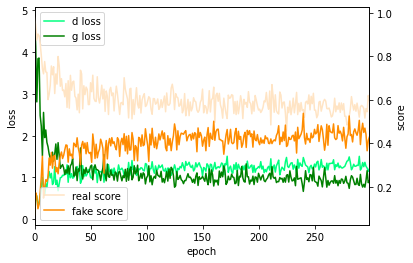

In [11]:
fig, loss_ax = plt.subplots()
score_ax = loss_ax.twinx()

loss_ax.plot(d_loss_history, 'springgreen', label='d loss')
loss_ax.plot(g_loss_history, 'green', label='g loss')

score_ax.plot(real_score_history, 'bisque', label='real score')
score_ax.plot(fake_score_history, 'darkorange', label='fake score')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
score_ax.set_ylabel('score')

loss_ax.legend(loc='upper left')
score_ax.legend(loc='lower left')

loss_ax.set_xlim([0,299])
plt.show()

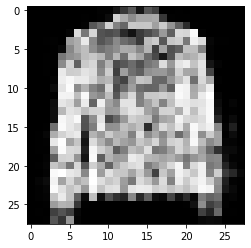

In [15]:
item_number = 6
z = torch.randn(1, 100).to(device)
g_label = torch.full((1,), item_number, dtype=torch.long).to(device)
sample_images = G(z, g_label)
sample_images_img = np.reshape(sample_images.data.cpu().numpy()[0],(28,28))
plt.imshow(sample_images_img, cmap='gray')
plt.show()